In [0]:
import tensorflow as tf
import numpy as np
import collections
import PIL.Image
import matplotlib.pyplot as plt

import scipy.io
import os
import argparse
import collections

In [0]:
# utils.py
"""Helper-functions for image manipulation"""
# This function loads an image and returns it as a numpy array of floating-points.
# The image can be automatically resized so the largest of the height or width equals max_size.
# or resized to the given shape
def load_image(filename, shape=None, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = float(max_size) / np.max(image.size)

        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS) # PIL.Image.LANCZOS is one of resampling filter

    if shape is not None:
        image = image.resize(shape, PIL.Image.LANCZOS) # PIL.Image.LANCZOS is one of resampling filter

    # Convert to numpy floating-point array.
    return np.float32(image)
    #return tf.convert_to_tensor(image)

# Save an image as a jpeg-file.
# The image is given as a numpy array with pixel-values between 0 and 255.
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert to bytes.
    image = image.astype(np.uint8)

    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

# This function plots the content-, mixed- and style-images.
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation='sinc')
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation='sinc')
    ax.set_xlabel("Output")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation='sinc')
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
# vgg19.py
# Copyright (c) 2015-2016 Anish Athalye. Released under GPLv3.
# Most code in this file was borrowed from https://github.com/anishathalye/neural-style/blob/master/vgg.py

def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)

def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

def preprocess(image, mean_pixel):
    return image - mean_pixel

def undo_preprocess(image, mean_pixel):
    return image + mean_pixel

class VGG19:
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    def __init__(self, data_path):
        data = scipy.io.loadmat(data_path)

        self.mean_pixel = np.array([123.68, 116.779, 103.939])

        self.weights = data['layers'][0]

    def preprocess(self, image):
        return image-self.mean_pixel

    def undo_preprocess(self,image):
        return image+self.mean_pixel

    def feed_forward(self, input_image, scope=None):
        net = {}
        current = input_image

        with tf.variable_scope(scope):
            for i, name in enumerate(self.layers):
                kind = name[:4]
                if kind == 'conv':
                    kernels = self.weights[i][0][0][2][0][0]
                    bias = self.weights[i][0][0][2][0][1]

                    # matconvnet: weights are [width, height, in_channels, out_channels]
                    # tensorflow: weights are [height, width, in_channels, out_channels]
                    kernels = np.transpose(kernels, (1, 0, 2, 3))
                    bias = bias.reshape(-1)

                    current = _conv_layer(current, kernels, bias)
                elif kind == 'relu':
                    current = tf.nn.relu(current)
                elif kind == 'pool':
                    current = _pool_layer(current)
                net[name] = current

        assert len(net) == len(self.layers)
        return net

In [0]:
# Style_transfer

class StyleTransfer:

    def __init__(self, content_layer_ids, style_layer_ids, init_image, content_image,
                 style_image, session, net, num_iter, loss_ratio, content_loss_norm_type):

        self.net = net
        self.sess = session

        # sort layers info
        self.CONTENT_LAYERS = collections.OrderedDict(sorted(content_layer_ids.items()))
        self.STYLE_LAYERS = collections.OrderedDict(sorted(style_layer_ids.items()))

        # preprocess input images
        self.p0 = np.float32(self.net.preprocess(content_image))
        self.a0 = np.float32(self.net.preprocess(style_image))
        self.x0 = np.float32(self.net.preprocess(init_image))

        # parameters for optimization
        self.content_loss_norm_type = content_loss_norm_type
        self.num_iter = num_iter
        self.loss_ratio = loss_ratio

        # build graph for style transfer
        self._build_graph()

    def _build_graph(self):

        """ prepare data """
        # this is what must be trained
        self.x = tf.Variable(self.x0, trainable=True, dtype=tf.float32)

        # graph input
        self.p = tf.placeholder(tf.float32, shape=self.p0.shape, name='content')
        self.a = tf.placeholder(tf.float32, shape=self.a0.shape, name='style')

        # get content-layer-feature for content loss
        content_layers = self.net.feed_forward(self.p, scope='content')
        self.Ps = {}
        for id in self.CONTENT_LAYERS:
            self.Ps[id] = content_layers[id]

        # get style-layer-feature for style loss
        style_layers = self.net.feed_forward(self.a, scope='style')
        self.As = {}
        for id in self.STYLE_LAYERS:
            self.As[id] = self._gram_matrix(style_layers[id])
        
        # get layer-values for x
        self.Fs = self.net.feed_forward(self.x, scope='mixed')

        """ compute loss """
        L_content = 0
        L_style = 0
        for id in self.Fs:
            if id in self.CONTENT_LAYERS:
                ## content loss ##

                F = self.Fs[id]            # content feature of x
                P = self.Ps[id]            # content feature of p

                _, h, w, d = F.get_shape() # first return value is batch size (must be one)
                N = h.value*w.value        # product of width and height
                M = d.value                # number of filters

                w = self.CONTENT_LAYERS[id]# weight for this layer

                # You may choose different normalization constant
                if self.content_loss_norm_type==1:
                    L_content += w * tf.reduce_sum(tf.pow((F-P), 2)) / 2 # original paper
                elif self.content_loss_norm_type == 2:
                    L_content += w * tf.reduce_sum(tf.pow((F-P), 2)) / (N*M) #artistic style transfer for videos
                elif self.content_loss_norm_type == 3: # this is from https://github.com/cysmith/neural-style-tf/blob/master/neural_style.py
                    L_content += w * (1. / (2. * np.sqrt(M) * np.sqrt(N))) * tf.reduce_sum(tf.pow((F - P), 2))

            elif id in self.STYLE_LAYERS:
                ## style loss ##

                F = self.Fs[id]

                _, h, w, d = F.get_shape()  # first return value is batch size (must be one)
                N = h.value * w.value       # product of width and height
                M = d.value                 # number of filters

                w = self.STYLE_LAYERS[id]   # weight for this layer

                G = self._gram_matrix(F)    # style feature of x
                A = self.As[id]             # style feature of a

                L_style += w * (1. / (4 * N ** 2 * M ** 2)) * tf.reduce_sum(tf.pow((G-A), 2))


        # fix beta as 1
        alpha = self.loss_ratio
        beta = 1

        self.L_content = L_content
        self.L_style = L_style
        self.L_total = alpha*L_content + beta*L_style

    def update(self):
        """ define optimizer L-BFGS """
        # this call back function is called every after loss is updated
        global _iter
        _iter = 0
        def callback(tl, cl, sl):
            global _iter
            print('iter : %4d, ' % _iter, 'L_total : %g, L_content : %g, L_style : %g' % (tl, cl, sl))
            _iter += 1

        optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.L_total, method='L-BFGS-B', options={'maxiter': self.num_iter})

        """ session run """
        # initialize variables
        init_op = tf.global_variables_initializer()
        self.sess.run(init_op)

        # optmization
        optimizer.minimize(self.sess,feed_dict={self.a:self.a0, self.p:self.p0},
                           fetches=[self.L_total, self.L_content, self.L_style], loss_callback=callback)

        """ get final result """
        final_image = self.sess.run(self.x)

        # ensure the image has valid pixel-values between 0 and 255
        final_image = np.clip(self.net.undo_preprocess(final_image), 0.0, 255.0)

        return final_image

    def _gram_matrix(self, tensor):

        shape = tensor.get_shape()

        # Get the number of feature channels for the input tensor,
        # which is assumed to be from a convolutional layer with 4-dim.
        num_channels = int(shape[3])

        # Reshape the tensor so it is a 2-dim matrix. This essentially
        # flattens the contents of each feature-channel.
        matrix = tf.reshape(tensor, shape=[-1, num_channels])

        # Calculate the Gram-matrix as the matrix-product of
        # the 2-dim matrix with itself. This calculates the
        # dot-products of all combinations of the feature-channels.
        gram = tf.matmul(tf.transpose(matrix), matrix)

        return gram


In [5]:
# Get the pretrained VGG19
! curl -O  'http://www.vlfeat.org/matconvnet/models/imagenet-vgg-verydeep-19.mat'

# Set the downloaded vgg19 as a variable
model_file_path = 'imagenet-vgg-verydeep-19.mat'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  510M  100  510M    0     0  21.1M      0  0:00:24  0:00:24 --:--:-- 22.5M


In [6]:
# We have three ways to upload the image files to the workspace.

# 1. uploading from somewhere using HTTP.
! curl -O  'https://raw.githubusercontent.com/suyongeum/PMLWS2018_WS3/master/starry-night.jpg'
! curl -O  'https://raw.githubusercontent.com/suyongeum/PMLWS2018_WS3/master/tubingen.jpg'

style_photo     = 'starry-night.jpg'
content_photo   = 'tubingen.jpg'

# # 2. uploading from your local machine.
# from google.colab import files
# upload = files.upload()

# style_photo     = 'starry-night.jpg'
# content_photo   = 'tubingen.jpg'


# # 3. uploading from your gdrive.
# from google.colab import drive
# drive.mount('/gdrive/')

# style_photo     = '/gdrive/My Drive/Colab Notebooks/starry-night.jpg'
# content_photo   = '/gdrive/My Drive/Colab Notebooks/tubingen.jpg'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  200k  100  200k    0     0   480k      0 --:--:-- --:--:-- --:--:--  480k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  397k  100  397k    0     0   874k      0 --:--:-- --:--:-- --:--:--  872k


In [0]:
# initiate VGG19 model
vgg_net = VGG19(model_file_path)

# load content image and style image
content_image = load_image(content_photo, max_size=500)
style_image = load_image(style_photo, shape=(content_image.shape[1],content_image.shape[0]))

# initial guess for output
init_image = content_image

# check input images for style-transfer
# utils.plot_images(content_image,style_image, init_image)

# create a map for content layers info
content_layers = ['conv4_2']
content_layer_weights = [1.0]

CONTENT_LAYERS = {}
for layer, weight in zip(content_layers, content_layer_weights):
    CONTENT_LAYERS[layer] = weight    
    
# create a map for style layers info
style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
style_layer_weights = [.2,.2,.2,.2,.2]

STYLE_LAYERS = {}
for layer, weight in zip(style_layers, style_layer_weights):
    STYLE_LAYERS[layer] = weight

        
###############################################################################
# open session
#sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))

config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC'
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
###############################################################################

In [0]:
"""add one dim for batch"""
# VGG19 requires input dimension to be (batch, height, width, channel)
def add_one_dim(image):
    shape = (1,) + image.shape
    return np.reshape(image, shape)
# build the graph
st = StyleTransfer(session = sess,
                   content_layer_ids = CONTENT_LAYERS,
                   style_layer_ids = STYLE_LAYERS,
                   init_image = add_one_dim(init_image),
                   content_image = add_one_dim(content_image),
                   style_image = add_one_dim(style_image),
                   net = vgg_net,
                   num_iter = 200, 
                   loss_ratio = 1e-3,
                   content_loss_norm_type = 3,
                   )

iter :    0,  L_total : 3.73472e+09, L_content : 7.73307e-05, L_style : 3.73472e+09
iter :    1,  L_total : 3.73302e+09, L_content : 113.618, L_style : 3.73302e+09
iter :    2,  L_total : 3.72622e+09, L_content : 2853.31, L_style : 3.72622e+09
iter :    3,  L_total : 3.699e+09, L_content : 51160.7, L_style : 3.699e+09
iter :    4,  L_total : 3.59054e+09, L_content : 867455, L_style : 3.59054e+09
iter :    5,  L_total : 3.19681e+09, L_content : 1.22084e+07, L_style : 3.1968e+09
iter :    6,  L_total : 1.23829e+09, L_content : 3.01029e+08, L_style : 1.23799e+09
iter :    7,  L_total : 8.6655e+08, L_content : 5.67803e+08, L_style : 8.65982e+08
iter :    8,  L_total : 4.73587e+08, L_content : 4.95124e+08, L_style : 4.73092e+08
iter :    9,  L_total : 4.06727e+08, L_content : 5.09456e+08, L_style : 4.06217e+08
iter :   10,  L_total : 2.46496e+08, L_content : 6.05207e+08, L_style : 2.45891e+08
iter :   11,  L_total : 1.87794e+08, L_content : 6.19673e+08, L_style : 1.87175e+08
iter :   12,  L

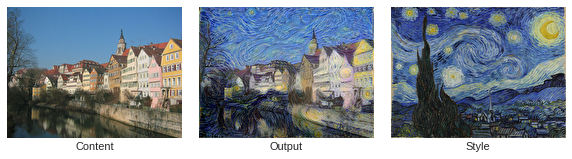

In [9]:
# launch the graph in a session
result_image = st.update()

# close session
sess.close()

# remove batch dimension
shape = result_image.shape
result_image = np.reshape(result_image,shape[1:])

# save result
save_image(result_image, 'result.jpg')
plot_images(content_image, style_image, result_image)

In [0]:
# download the result into your local disk
from google.colab import files
files.download('result.jpg')